

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

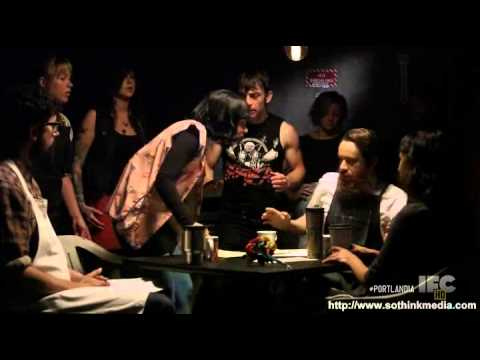

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('Jml7NVYm8cs')

#0. Prepare

## 0.1 Get spacy

In [2]:
# Locally (or on colab) let's use en_core_web_lg 
!python -m spacy download en_core_web_lg # Can do lg, takes awhile
# Also on Colab, need to restart runtime after this step!

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-23 02:01:34.083027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 02:01:36.704262: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-23 02:01:36.704436: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open share

## 0.2 Restart runtime!

## 0.3 Install packages and do imports

In [1]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import squarify

-----

## 0.4 Get data

In [3]:
url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/module1-text-data/data/yelp_coffeeshop_review_data.csv"

df = pd.read_csv(url)
df.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [4]:
df.full_review_text.iloc[0]

' 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? '

In [5]:
df.full_review_text.iloc[0:3]

0     11/25/2016 1 check-in Love love loved the atm...
1     12/2/2016 Listed in Date Night: Austin, Ambia...
2     11/30/2016 1 check-in Listed in Brunch Spots ...
Name: full_review_text, dtype: object

Let's create a function for quickly getting a print out of our text reviews. Since we'll be performing various data cleaning and tokenizing operations, we'll be wanting to print out our text numerous times, so it'll be useful to have a function for that very thing!

In [6]:
# computationally efficient way to iterate through rows using iterrows()
# we just want to see the print out of few reviews to get an idea of the  
# quality of our text data (i.e. how messy is it?)

def print_out_N_reviews(N, df, col_name='full_review_text'):
  """
  Prints out <N> number of text reviews for a specified column <col_name>

  Parameters
  ----------
  N : int
      Number of text reviews to print out

  df : pandas dataframe

  col_name : string
      Column name where the text reviews are stored

  Returns
  -------
  None
  """

  counter = 0 
  # by using double brackets in df[[col_name]] the data type stays as a 
  # dataframe instead of becoming a Series had we used single brackets

  for row_id, row in df[[col_name]].iterrows():

    text = row[0] # get column data
    print(text)
    print(' ') # create a blank line for ease of reading
    if counter == N: # exit for loop after printing out a few reviews
      break
    counter += 1

In [7]:
N = 5
print_out_N_reviews(N, df)

 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? 
 
 12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Instagram-worthy!!!  Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) Waffle dessert was just decent...nothing to rave about.  But, will probably be back just to be somewhere unique and nice. 
 
 11/30/2016 1 check-in Listed in Brunch Spots I loved the eclectic and homey plush decor and who doesn't want to swing and d

**Observations**

The text above have the following characteristics:

- Reviews have dates
- Lots of punctutation
- Special characters linke $ ( as well as dollar amounts)
- Upper and lower case words

Let's clean the data using a single function.


# 1 Practice: Clean, tokenize, remove stop words, lemmatize

## 1.1 Clean Review Text (with Regular Expressions `regex`)
dataquest has a good [regex reference](https://www.dataquest.io/wp-content/uploads/2019/03/python-regular-expressions-cheat-sheet.pdf
)


In [8]:
import re
# considering using regex to remove dates
# you can create and test regular expressions on this online regex editor: 
# https://regex101.com/
    
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in 
    order to clean the document. 
    
    Parameters
    ----------
    text: string or object 
    
    Returns
    -------
    text: string or object
    """
    
    # order of operations - apply the expression from top to bottom
    date_regex = r"\d+/\d+/\d+"
    punct_regex = r"[^0-9a-zA-Z\s]" # any non-alphanumeric chars
    special_chars_regex = r"[\$\%\&\@+]" 
    numerical_regex = r"\d+"  # match one or more digits
    
    # Replace any strings matching the above regex patterns with blank strings
    # (effectively removing them from the text)
    text = re.sub(date_regex, "", text)
    text = re.sub(punct_regex, "", text)
    text = re.sub(special_chars_regex, "", text)
    text = re.sub(numerical_regex, "", text)

    # apply case normalization
    text = text.lower()
    return text

In [9]:
df.full_review_text = df.full_review_text.apply(lambda text: clean_data(text))

In [10]:
N = 5 
print_out_N_reviews(N, df, col_name='full_review_text')

   checkin love love loved the atmosphere every corner of the coffee shop had its own style and there were swings i ordered the matcha latte and it was muy fantastico ordering and getting my drink were pretty streamlined i ordered on an ipad which included all beverage selections that ranged from coffee to wine desired level of sweetness and a checkout system i got my latte within minutes  i was hoping for a typical heart or feather on my latte but found myself listing out all the possibilities of what the art may be any ideas 
 
  listed in date night austin ambiance in austin beautiful love the ambiance instagramworthy  definitely  so be prepared this is gonna cost you a pretty penny  waffle dessert was just decentnothing to rave about  but will probably be back just to be somewhere unique and nice 
 
   checkin listed in brunch spots i loved the eclectic and homey plush decor and who doesnt want to swing and drink their coffee  i would categorize this as a pricier coffee place but t

**Observations:**

The text looks a lot cleaner after using regex to remove characters that we don't want to consider as tokens. 

We are motivated to get high quality tokens because eventually, we are going to create a document-term matrix using the tokens in our documents. Which means that each token will become a feature in that matrix. 

Features such as white spaces, punctuation, dates and numbers are generally not very informative features for ML models.

## 1.2. Tokenize the text

Now that we have done some data cleaning, we can create some tokens. Notice in the above print out of some of the reviews that there are white spaces where periods used to be. It's a bit difficult to strip those extra white spaces when handeling an entire text document, but it becomes much easier to strip out all of those extra white spaces when handeling tokens - so let's create some tokens!

In [12]:
import spacy
# import the large version of the pre-trained model
# depending on your computational resources/limitations, you might  
# need to download and load in a smaller version of the model 
# see the spaCy docs: https://spacy.io/models/en
nlp = spacy.load('en_core_web_lg')

In [13]:
# this will take longer to run than a regex method because Spacy is doing a 
# fair amount of extra stuff under the hood in creating the token attributes 
# and everything.

def tokenizer(text):
    """
    Use the pre-trained model from Space to tokenize our text into lemmas 
    
    Notes
    -----
    Remember that the pre-trained spaCy model has a lot of built in flags  
    for what kind of token each token is so we can use that functionality to 
    create filters for stop words, white spaces, punctuation, and so on!
    
    See list of flags here: https://spacy.io/api/token#attributes
    
    Parameter
    ---------
    text: string
        Full text article/document that needs to be tokenized 
    """

    # pass the text into the spaCy pre-trained model so that we can then use
    # the useful spaCy functionality

    doc = nlp(text)

    # provide a stop word filter (i.e. remove stop words) and a white space
    # filter (i.e. remove tokens that are white space) 
    return [token.lemma_ for token in doc if (token.is_stop != True) and 
            (token.is_space != True)]

In [14]:
# This might take ~4 minutes
df['lemmas'] = df.full_review_text.apply(lambda text: tokenizer(text))

In [15]:
# We have removed the white spaces and we now have lemmas for tokens!
df.lemmas.iloc[:5]

0    [checkin, love, love, love, atmosphere, corner...
1    [list, date, night, austin, ambiance, austin, ...
2    [checkin, list, brunch, spot, love, eclectic, ...
3    [cool, decor, good, drink, nice, seating, over...
4    [checkin, locate, northcross, mall, shopping, ...
Name: lemmas, dtype: object

In [16]:
df.head()

,coffee_shop_name,full_review_text,star_rating,lemmas
0,The Factory - Cafe With a Soul,checkin love love loved the atmosphere ever...,5.0 star rating,"[checkin, love, love, love, atmosphere, corner..."
1,The Factory - Cafe With a Soul,listed in date night austin ambiance in aust...,4.0 star rating,"[list, date, night, austin, ambiance, austin, ..."
2,The Factory - Cafe With a Soul,checkin listed in brunch spots i loved the ...,4.0 star rating,"[checkin, list, brunch, spot, love, eclectic, ..."
3,The Factory - Cafe With a Soul,very cool decor good drinks nice seating ho...,2.0 star rating,"[cool, decor, good, drink, nice, seating, over..."
4,The Factory - Cafe With a Soul,checkin they are located within the northcr...,4.0 star rating,"[checkin, locate, northcross, mall, shopping, ..."




---


## 2. How do we want to analyze these coffee shop tokens?

- Overall word/token count
- View counts by rating
- *Hint:* a 'bad' coffee shop has a rating between 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5.


As a starting point let;s work through the following:

1. Label reviews as either **good** or **bad** depending on their star rating
2. Use the **count** function from lecture to perform some statistical analysis of our tokens

### **2.1. Label reviews as either good or bad depending on their star rating**

In [17]:
# notice how the star_rating is an object data type?
# that's because it's a combination of a number of text data
# so we need to strip the text and cast the number as a floating point

df.dtypes

coffee_shop_name    object
full_review_text    object
star_rating         object
lemmas              object
dtype: object

In [18]:
df.star_rating.iloc[:3]

0     5.0 star rating 
1     4.0 star rating 
2     4.0 star rating 
Name: star_rating, dtype: object

In [19]:
def get_sentiment(rating):
  """
  Accepts a string or object data type star review and returns a numerical score for the review sentiment.

  Parameters
  ----------
  rating : string or object

  Returns
  -------
  sentiment score : boolean
  """

  # strip out the text and convert string number into float number
  num_rating = float(rating[:2])

  # assign sentiment numerically
  if num_rating >=4:
    # 1 means positive sentiment
    return 1
  else:
    # 0 means negative sentiment
    return 0

In [20]:
df['sentiment'] = df.star_rating.apply(lambda rating: get_sentiment(rating))

In [21]:
df.head()

,coffee_shop_name,full_review_text,star_rating,lemmas,sentiment
0,The Factory - Cafe With a Soul,checkin love love loved the atmosphere ever...,5.0 star rating,"[checkin, love, love, love, atmosphere, corner...",1
1,The Factory - Cafe With a Soul,listed in date night austin ambiance in aust...,4.0 star rating,"[list, date, night, austin, ambiance, austin, ...",1
2,The Factory - Cafe With a Soul,checkin listed in brunch spots i loved the ...,4.0 star rating,"[checkin, list, brunch, spot, love, eclectic, ...",1
3,The Factory - Cafe With a Soul,very cool decor good drinks nice seating ho...,2.0 star rating,"[cool, decor, good, drink, nice, seating, over...",0
4,The Factory - Cafe With a Soul,checkin they are located within the northcr...,4.0 star rating,"[checkin, locate, northcross, mall, shopping, ...",1


### **2.2. Use the count function from lecture to perform some statistical analysis of our tokens**

In [22]:
from collections import Counter

def count(tokens):
    """
    Calculates some basic statistics about tokens in our corpus (i.e. corpus means collections text data)

    Parameters
    ----------
    tokens : pandas Series or list of lists

    Returns
    -------
    wc : pandas DataFrame
    """

    # stores the count of each token
    word_counts = Counter()
    
    # stores the number of docs that each token appears in 
    appears_in = Counter()

    total_docs = len(tokens)

    for token in tokens:
        # stores count of every appearance of a token 
        word_counts.update(token)   
        # use set() in order to not count duplicates, thereby count the num of 
        # docs that each token appears in
        appears_in.update(set(token))

    # build word count dataframe
    temp = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # rank the the word counts
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # calculate the percent total of each token
    wc['pct_total'] = wc['count'].apply(lambda token_count: token_count / total * 100)

    # calculate the cumulative percent total of word counts 
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    # create dataframe for document stats
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    
    # merge word count stats with doc stats
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs * 100)

    return wc.sort_values(by='rank')

In [23]:
df_wc = count(df['lemmas'])

#### Summary of the descriptive token statistics 

`word` The specific token that is being analyzed

`appears_in` Number of documents that the word/token appears in

`count` The total number of appearances of that token within the corpus 

`rank` Ranking of tokens by count 

`pct_total` Percent of the total tokens that this token makes up

`cul_pct_total` Cumulative percent total of ranked tokens

`appears_in_pct` Percentage of documents that token appears in 

In [24]:
df_wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
29,coffee,4923,10593,1.0,2.942288,2.942288,64.640231
110,place,3888,6044,2.0,1.678768,4.621055,51.050420
157,good,3596,5392,3.0,1.497670,6.118725,47.216387
116,not,3055,5175,4.0,1.437396,7.556121,40.112920
98,great,2853,3946,5.0,1.096032,8.652153,37.460609
153,like,2261,3351,6.0,0.930766,9.582919,29.687500
4,checkin,2969,2985,7.0,0.829107,10.412026,38.983718
436,come,1934,2634,8.0,0.731614,11.143640,25.393908
38,love,1816,2372,9.0,0.658841,11.802481,23.844538
464,time,1749,2372,10.0,0.658841,12.461322,22.964811


**Visualize top N tokens using a word cloud**

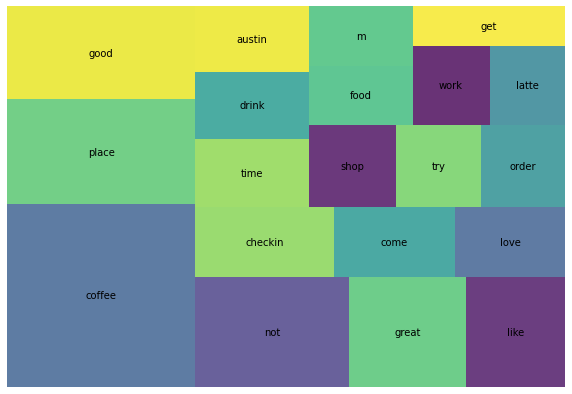

In [27]:
# visualize the 20 most common tokens with squarify
# Lots of stopwords!

top_N_tokens = 20
wc_top20 = df_wc[df_wc['rank'] <= top_N_tokens] 

plt.figure(figsize=(10,7))
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

**Observation:**

In the word cloud, we can see that there are some words that could be considered stop words such as try, get, m and even the word coffee. One such futher step that we could take is to expand the default stop word set that the pre-trained spacy model has.

**Visualize the cumulative percent total of tokens**

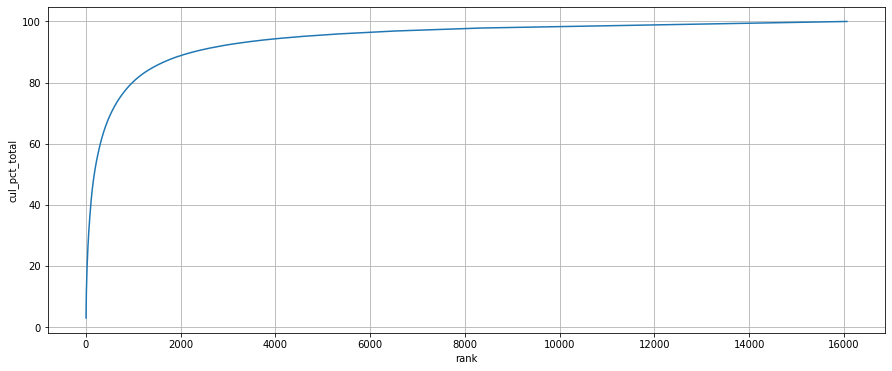

In [29]:
plt.figure(figsize=(15,6))
plt.grid()
# Frequency if appears in documents
sns.lineplot(x='rank', y='cul_pct_total', data=df_wc);

We can see that a very small number of words /tokens make up a very large percentage of total token counts in our corpus. In other words, there are relatively few words that are used a lot in writing. Thinking back to the word cloud we just created, it's likely safe to assume that a lot of these words are stop words. Again, further analysis will have to be done in order to identify those words that one should consider adding to the stop word set. 

Let's take the output of the count function and try to answer a question regarding this plot we just created.

Looking at the above plot, the following question comes to mind: **What percentage of tokens make up the 80% of all tokens that appear in our corpus?**

**Why focus on 80%?** Why not 50% or 60%? The motivation for choosing 80% brings us to the Pareto Principle sometimes referred as the 80/20 rule.

It states that `roughly 80% of the consequences/output/ results come from 20% of the causes/input`. This is a good principle to keep in mind as Data Scientist. It pops up a lot.

In [33]:
# let's create a mask that keeps the tokens that make up 80% of all 
# tokens counts
less_than_80_mask = df_wc['cul_pct_total'] < 80
N_words_below_80 = df_wc['cul_pct_total'][less_than_80_mask].shape[0]
N_words_below_80 # this is how many tokens make up 80% of all token counts

979

In [35]:
total_N_tokens =  df_wc.shape[0]
total_N_tokens # this is the total number of unique tokens in our corpus

16066

In [37]:
# percentage of tokens that make up 80% of alltoken counts, 
# which is far less than 20% 
N_words_below_80/total_N_tokens * 100

6.093613842898046

**Visualize the words with the greates difference in counts between 'good' and 'bad'**

Couple Notes:
- Rel.freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences

In order to compare the relative frequency of token counts between good and bad reviews, let's do the following.

1. Split the data between good and bad reviews
2. Re-apply the count function on each split
3. Sort through the results and make some observations


**1. Split the data between good and bad reviews**

In [38]:
df.head()

,coffee_shop_name,full_review_text,star_rating,lemmas,sentiment
0,The Factory - Cafe With a Soul,checkin love love loved the atmosphere ever...,5.0 star rating,"[checkin, love, love, love, atmosphere, corner...",1
1,The Factory - Cafe With a Soul,listed in date night austin ambiance in aust...,4.0 star rating,"[list, date, night, austin, ambiance, austin, ...",1
2,The Factory - Cafe With a Soul,checkin listed in brunch spots i loved the ...,4.0 star rating,"[checkin, list, brunch, spot, love, eclectic, ...",1
3,The Factory - Cafe With a Soul,very cool decor good drinks nice seating ho...,2.0 star rating,"[cool, decor, good, drink, nice, seating, over...",0
4,The Factory - Cafe With a Soul,checkin they are located within the northcr...,4.0 star rating,"[checkin, locate, northcross, mall, shopping, ...",1


In [39]:
# split the data set into a positive and negative sentiment data set
pos_mask = df.sentiment == 1
neg_mask = df.sentiment == 0

df_pos = df[pos_mask]
df_neg = df[neg_mask]

In [40]:
df_pos.head()

,coffee_shop_name,full_review_text,star_rating,lemmas,sentiment
0,The Factory - Cafe With a Soul,checkin love love loved the atmosphere ever...,5.0 star rating,"[checkin, love, love, love, atmosphere, corner...",1
1,The Factory - Cafe With a Soul,listed in date night austin ambiance in aust...,4.0 star rating,"[list, date, night, austin, ambiance, austin, ...",1
2,The Factory - Cafe With a Soul,checkin listed in brunch spots i loved the ...,4.0 star rating,"[checkin, list, brunch, spot, love, eclectic, ...",1
4,The Factory - Cafe With a Soul,checkin they are located within the northcr...,4.0 star rating,"[checkin, locate, northcross, mall, shopping, ...",1
5,The Factory - Cafe With a Soul,checkin very cute cafe i think from the mom...,4.0 star rating,"[checkin, cute, cafe, think, moment, step, not...",1


In [41]:
df_neg.head()

,coffee_shop_name,full_review_text,star_rating,lemmas,sentiment
3,The Factory - Cafe With a Soul,very cool decor good drinks nice seating ho...,2.0 star rating,"[cool, decor, good, drink, nice, seating, over...",0
8,The Factory - Cafe With a Soul,checkin ok lets try this approach pros mus...,3.0 star rating,"[checkin, ok, lets, try, approach, pro, music,...",0
11,The Factory - Cafe With a Soul,the store has a decoration but honestly the ...,3.0 star rating,"[store, decoration, honestly, coffee, good, co...",0
12,The Factory - Cafe With a Soul,checkin listed in the third time is a cha...,3.0 star rating,"[checkin, list, time, charm, factory, decor, i...",0
25,The Factory - Cafe With a Soul,okay so after visiting my friends in la and ...,1.0 star rating,"[okay, visit, friend, la, try, mint, mojito, i...",0


We can see from the .head() that the data seems to have been correctly split into a positive and negative sentiment sets but let's run a sanity check on our results.

In [42]:
# no error will print out if all values in the sentiment column are 1
assert df_pos.sentiment.all() == True

In [43]:
# no error will print out if there are no 1's in the sentiment column 
# (i.e. if there are all zeros)
assert df_neg.sentiment.any() == False

In [44]:
N_pos_reviews = df_pos.shape[0]
N_neg_reviews = df_neg.shape[0]
N_total_reviews = df.shape[0]

N_pos_reviews/ N_total_reviews * 100, N_neg_reviews/ N_total_reviews * 100

(80.61974789915966, 19.380252100840337)

**Observations**

- 80% of reviews are positive
- 20% of reviews are negative
- We have a highly unbalanced data set (with respect to the sentiment column)
  - If we were building a ML model for sentiments analysis, we would have to address the label imbalance


**2. Re-apply the count function on each split**

In [45]:
df_pos_wc = count(df_pos.lemmas)
df_neg_wc = count(df_neg.lemmas)

**3. Sort through the results and make some observations**

In [47]:
df_pos_wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
29,coffee,3975,8421,1.0,2.997885,2.997885,64.739414
110,place,3133,4816,2.0,1.714501,4.712387,51.026059
188,good,2946,4388,3.0,1.562133,6.274520,47.980456
98,great,2505,3474,4.0,1.236748,7.511267,40.798046
116,not,2187,3469,5.0,1.234968,8.746235,35.618893
4,checkin,2512,2525,6.0,0.898903,9.645138,40.912052
185,like,1669,2415,7.0,0.859743,10.504881,27.182410
38,love,1608,2120,8.0,0.754722,11.259603,26.188925
57,austin,1570,2012,9.0,0.716274,11.975877,25.570033
366,come,1482,1984,10.0,0.706306,12.682184,24.136808


In [48]:
df_neg_wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
32,coffee,948,2172,1.0,2.744920,2.744920,64.227642
108,not,868,1706,2.0,2.156000,4.900920,58.807588
11,place,755,1228,3.0,1.551916,6.452836,51.151762
28,good,650,1004,4.0,1.268830,7.721666,44.037940
22,like,592,936,5.0,1.182894,8.904560,40.108401
116,order,439,765,6.0,0.966788,9.871348,29.742547
147,come,452,650,7.0,0.821454,10.692802,30.623306
204,time,420,611,8.0,0.772167,11.464968,28.455285
24,drink,362,607,9.0,0.767112,12.232080,24.525745
143,food,316,494,10.0,0.624305,12.856385,21.409214


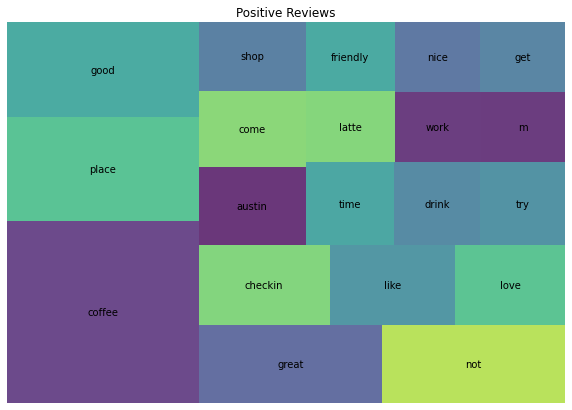

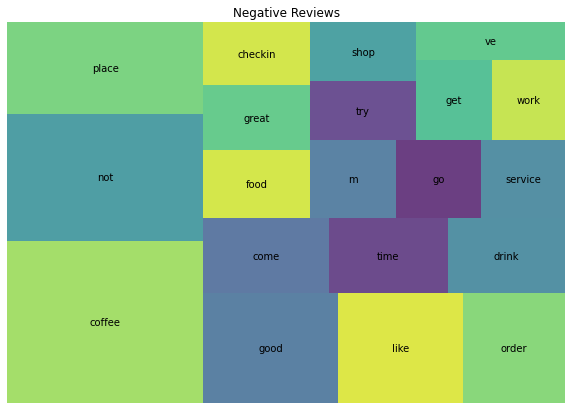

In [50]:
top_N_tokens = 20

wc_top20 = df_pos_wc[df_pos_wc['rank'] <= top_N_tokens] 

plt.figure(figsize=(10,7))
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.title('Positive Reviews')
plt.show()

wc_top20 = df_neg_wc[df_neg_wc['rank'] <= top_N_tokens] 

plt.figure(figsize=(10,7))
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.title('Negative Reviews')
plt.show()

A couple of observations is that **coffee** is the most common token in both data sets, though unsurprising. It might be a good idea to include coffee in the stop word set, since we know we are looking at coffee reviews a word like 'coffee' is expected to show up in most if not all reviews and so it doesn't really tell us much. A second observation is the appereance of the word **not**.

`"Not" appears in 58.8% of negative reviews and appears in 35.6% of positive reviews - that's a 23% difference!`

Is there a meaningful significance to that observation?

Maybe not appears more in negative reviews as an indication of negative sentiment, "Not great coffee", "this coffee is not cheap", "would not recommend..."

Let's use out `print_out_N_reviews` function to print out a few areviews from both data sets.



In [51]:
# an ad-hoc analysis shows that "not" is being used as an indicator of 
# dissatisfaction in negative reviews
N = 4
print_out_N_reviews(N, df_neg)

  very cool decor good drinks nice seating  however  just about everything is overpriced  extra for  ounces of almond milk in a cortado no wifi music is a bit loud and the mix is odd  pleasant french oldies followed by loud techno several tables were dirty when we got there service is average  it feels like a los angeles coffee shot that is out of place 
 
   checkin ok lets try this approach  pros music seating decor general ambiance service  cons ipad ordering im a crotchety old man kids limited coffee menu or menu in general relatively expensive food is pretty but lackluster  im still sitting here as i type this and im less than overjoyed with the experience sadly the space and vibe are great but not quite familiar or intimate enough to beat out a place like genuine joe down the street it seems like they bank on the vibe and fall short the rest of the way this would be a great hangout for the artsydesign crowd having a collaborative meeting  the staff is great but the ipad ordering 

In [53]:
# "not" appears twice in one review but the tone doesn't sound nearly as
# negative as the reviews from df_neg
N = 4
print_out_N_reviews(N, df_pos)

   checkin love love loved the atmosphere every corner of the coffee shop had its own style and there were swings i ordered the matcha latte and it was muy fantastico ordering and getting my drink were pretty streamlined i ordered on an ipad which included all beverage selections that ranged from coffee to wine desired level of sweetness and a checkout system i got my latte within minutes  i was hoping for a typical heart or feather on my latte but found myself listing out all the possibilities of what the art may be any ideas 
 
  listed in date night austin ambiance in austin beautiful love the ambiance instagramworthy  definitely  so be prepared this is gonna cost you a pretty penny  waffle dessert was just decentnothing to rave about  but will probably be back just to be somewhere unique and nice 
 
   checkin listed in brunch spots i loved the eclectic and homey plush decor and who doesnt want to swing and drink their coffee  i would categorize this as a pricier coffee place but t

## **More Thorough Analysis**

Let's take a look at the `df_pos_wc` and `df_neg_wc`. Notice certain words are ranked higher in one data set and not the other.

In [54]:
# these are words that are ranked higher in one data set but not the other
key_words = ['love', 'not', 'delicious', 'friendly', 'great']

In [56]:
df_pos_keywords_mask = df_pos_wc.word.isin(key_words)
df_pos_keywords = df_pos_wc[df_pos_keywords_mask]
df_pos_keywords.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
98,great,2505,3474,4.0,1.236748,7.511267,40.798046
116,not,2187,3469,5.0,1.234968,8.746235,35.618893
38,love,1608,2120,8.0,0.754722,11.259603,26.188925
161,friendly,1420,1487,16.0,0.529374,16.230803,23.127036
582,delicious,1178,1314,24.0,0.467785,20.242223,19.185668


In [57]:
df_neg_keywords_mask = df_neg_wc.word.isin(key_words)
df_neg_keywords = df_neg_wc[df_neg_keywords_mask]
df_neg_keywords.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
108,not,868,1706,2.0,2.156000,4.900920,58.807588
80,great,348,472,11.0,0.596502,13.452886,23.577236
280,love,208,252,40.0,0.318471,26.176575,14.092141
518,friendly,181,201,59.0,0.254019,31.648721,12.262873
378,delicious,83,88,157.0,0.111212,48.234506,5.623306


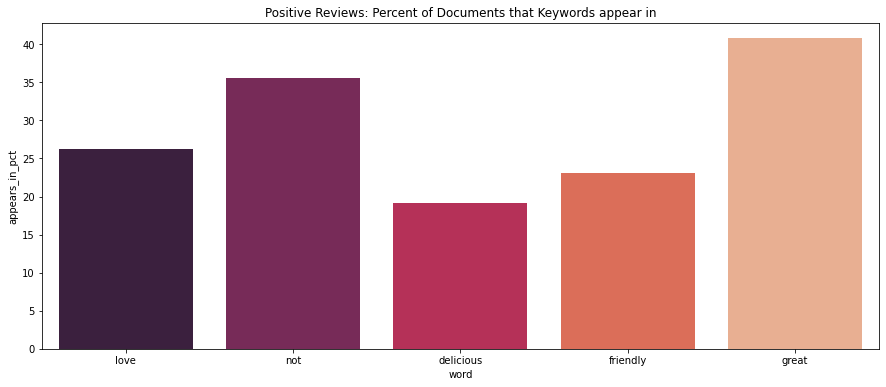

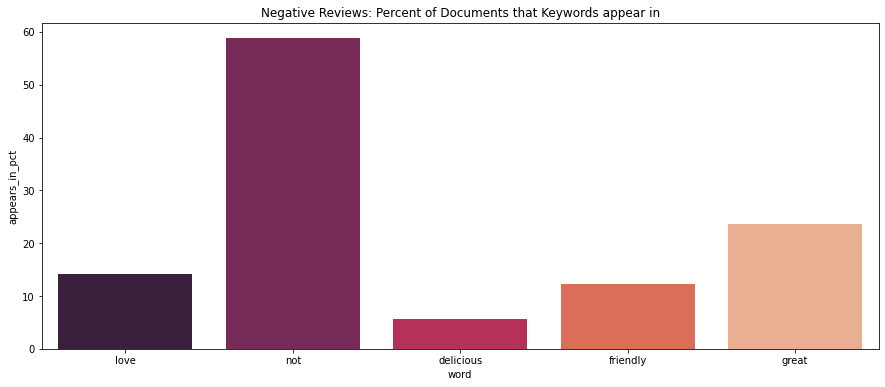

In [59]:
plt.figure(figsize=(15,6))
plt.title("Positive Reviews: Percent of Documents that Keywords appear in")
sns.barplot(x=df_pos_keywords.word, y=df_pos_keywords.appears_in_pct, palette="rocket", order=key_words);
plt.show();

plt.figure(figsize=(15,6))
plt.title("Negative Reviews: Percent of Documents that Keywords appear in")
sns.barplot(x=df_neg_keywords.word, y=df_neg_keywords.appears_in_pct, palette="rocket", order=key_words);
plt.show();

**Observations**

We can notice that the word **not** appears in higher percentage in negative reviews, and we can also see that certain highly positive sentiment words appear in far higher percentages in positive reviews than they do in negative reviews. These results line up with our intuitions on what to expect.

Notice how certain words are correlated with certain sentiment? This is the kind of thing we want to capture in our data before we pass it into Machine Learning models.